In [1]:
import random
from datetime import datetime

In [2]:
import torch
from torch import nn

In [3]:
from utils_random import set_random_seed
from utils_torch.data import stratified_random_split
from utils_attacker_lstm.data import DatasetAttackerLSTMPool, DataLoaderAttackerLSTM
from utils_attacker_lstm.models import ModelAttackerLSTMNew, TrainerAttackerLSTM, TesterAttackerLSTM, \
    ManagerAttackerLSTM
from utils_plot import plot_train_eval_loss_accuracy, plot_receiver_operating_characteristics_curve, \
    plot_confusion_matrix

In [4]:
model_id = datetime.now().strftime("%m%d%H%M")

In [5]:
random_seed = random.randint(0, 2 ** 32 - 1)

In [6]:
set_random_seed(random_seed)

In [7]:
num_snps = random.choice([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000])
train_eval_test_split = [0.7, 0.15, 0.15]

In [8]:
genome_batch_size = random.randint(16, 64)
snp_batch_size = num_snps

In [9]:
conv_num_layers = random.randint(1, 8)
conv_channel_size = [3] + [random.randint(16, 64) for _ in range(conv_num_layers)]
conv_kernel_size = [random.randint(4, 32) for _ in range(conv_num_layers)]
conv_stride = [random.randint(1, conv_kernel_size[i]) for i in range(conv_num_layers)]
conv_dilation = [random.randint(1, 4) for _ in range(conv_num_layers)]
conv_groups = [1 for _ in range(conv_num_layers)]

conv_activation = random.choice([nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU])
conv_activation_kwargs = {}

conv_dropout_p = [random.uniform(0, 0.66) for _ in range(conv_num_layers - 1)]
conv_dropout_first = [random.choice([True, False]) for _ in range(conv_num_layers - 1)]

conv_batch_norm = [random.choice([True, False]) for _ in range(conv_num_layers - 1)]
conv_batch_norm_momentum = [random.uniform(0, 1) for _ in range(conv_num_layers - 1)]

In [10]:
conv_lstm_activation = random.choice([nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU])
conv_lstm_activation_kwargs = {}

conv_lstm_dropout_p = random.uniform(0, 0.66)
conv_lstm_dropout_first = random.choice([True, False])

conv_lstm_layer_norm = random.choice([True, False])

In [11]:
lstm_num_layers = random.randint(1, 4)
lstm_input_size = conv_channel_size[-1]
lstm_hidden_size = [random.randint(4, 64) for _ in range(lstm_num_layers)]
lstm_proj_size = [0 for _ in range(lstm_num_layers)]
lstm_bidirectional = [random.choice([True, False]) for _ in range(lstm_num_layers)]

lstm_dropout_p = [random.uniform(0, 0.66) for _ in range(lstm_num_layers - 1)]
lstm_dropout_first = [random.choice([True, False]) for _ in range(lstm_num_layers - 1)]

lstm_layer_norm = [random.choice([True, False]) for _ in range(lstm_num_layers - 1)]

In [12]:
lstm_linear_dropout_p = random.uniform(0, 0.66)
lstm_linear_dropout_first = random.choice([True, False])

lstm_linear_batch_norm = random.choice([True, False])
lstm_linear_batch_norm_momentum = random.uniform(0, 1)

In [13]:
linear_num_layers = random.randint(1, 4)
linear_num_features = [lstm_hidden_size[-1] * (2 if any(lstm_bidirectional) else 1)] + [random.randint(4, 64) for _ in
                                                                                        range(
                                                                                            linear_num_layers - 1)] + [
                          1]

linear_activation = random.choice([nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU])
linear_activation_kwargs = {}

linear_dropout_p = [random.uniform(0, 0.66) for _ in range(linear_num_layers - 1)]
linear_dropout_first = [random.choice([True, False]) for _ in range(linear_num_layers - 1)]

linear_batch_norm = [random.choice([True, False]) for _ in range(linear_num_layers - 1)]
linear_batch_norm_momentum = [random.uniform(0, 1) for _ in range(linear_num_layers - 1)]

In [14]:
num_epochs = 256
learning_rate = 0.001

In [15]:
models_dir = "../models"
models_file = "models.csv"
plots_dir = "../plots"

In [16]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [17]:
dataset = DatasetAttackerLSTMPool(
    genomes_pool_path="../data/test/In_Pop.pkl",
    genomes_reference_path="../data/test/Not_In_Pop.pkl",
    num_snps=num_snps)
subset_train, subset_eval, subset_test = stratified_random_split(dataset=dataset,
                                                                 ratios=train_eval_test_split)

In [18]:
dataloader_train = DataLoaderAttackerLSTM(
    dataset=subset_train,
    genome_batch_size=genome_batch_size,
    snp_batch_size=snp_batch_size,
    shuffle=True)
dataloader_eval = DataLoaderAttackerLSTM(
    dataset=subset_eval,
    genome_batch_size=genome_batch_size,
    snp_batch_size=snp_batch_size,
    shuffle=False)
dataloader_test = DataLoaderAttackerLSTM(
    dataset=subset_test,
    genome_batch_size=genome_batch_size,
    snp_batch_size=snp_batch_size,
    shuffle=False)

In [19]:
model = ModelAttackerLSTMNew(
    conv_num_layers=conv_num_layers,
    conv_channel_size=conv_channel_size,
    conv_kernel_size=conv_kernel_size,
    conv_stride=conv_stride,
    conv_dilation=conv_dilation,
    conv_groups=conv_groups,
    conv_activation=conv_activation,
    conv_activation_kwargs=conv_activation_kwargs,
    conv_dropout_p=conv_dropout_p,
    conv_dropout_first=conv_dropout_first,
    conv_batch_norm=conv_batch_norm,
    conv_batch_norm_momentum=conv_batch_norm_momentum,
    conv_lstm_activation=conv_lstm_activation,
    conv_lstm_activation_kwargs=conv_lstm_activation_kwargs,
    conv_lstm_dropout_p=conv_lstm_dropout_p,
    conv_lstm_dropout_first=conv_lstm_dropout_first,
    conv_lstm_layer_norm=conv_lstm_layer_norm,
    lstm_num_layers=lstm_num_layers,
    lstm_input_size=lstm_input_size,
    lstm_hidden_size=lstm_hidden_size,
    lstm_proj_size=lstm_proj_size,
    lstm_bidirectional=lstm_bidirectional,
    lstm_dropout_p=lstm_dropout_p,
    lstm_dropout_first=lstm_dropout_first,
    lstm_layer_norm=lstm_layer_norm,
    lstm_linear_dropout_p=lstm_linear_dropout_p,
    lstm_linear_dropout_first=lstm_linear_dropout_first,
    lstm_linear_batch_norm=lstm_linear_batch_norm,
    lstm_linear_batch_norm_momentum=lstm_linear_batch_norm_momentum,
    linear_num_layers=linear_num_layers,
    linear_num_features=linear_num_features,
    linear_activation=linear_activation,
    linear_activation_kwargs=linear_activation_kwargs,
    linear_dropout_p=linear_dropout_p,
    linear_dropout_first=linear_dropout_first,
    linear_batch_norm=linear_batch_norm,
    linear_batch_norm_momentum=linear_batch_norm_momentum)
model.to(device)

ModelAttackerLSTMNew(
  (_conv_stack): Conv1dStack(
    (_conv_modules): ModuleList(
      (0): Conv1d(3, 53, kernel_size=(26,), stride=(7,), dilation=(3,))
      (1): Conv1d(53, 25, kernel_size=(29,), stride=(29,), dilation=(2,))
      (2): Conv1d(25, 50, kernel_size=(23,), stride=(7,), dilation=(3,))
    )
    (_activation_modules): ModuleList(
      (0-1): 2 x LeakyReLU(negative_slope=0.01)
    )
    (_dropout_modules): ModuleList(
      (0): Dropout(p=0.5514312621068906, inplace=False)
      (1): Dropout(p=0.0211081259551303, inplace=False)
    )
    (_batch_norm_modules): ModuleList(
      (0): Identity()
      (1): BatchNorm1d(25, eps=1e-05, momentum=0.09844852851404062, affine=True, track_running_stats=True)
    )
  )
  (_conv_lstm_activation_module): LeakyReLU(negative_slope=0.01)
  (_conv_lstm_dropout_module): Dropout(p=0.1968930046641182, inplace=False)
  (_conv_lstm_layer_norm_module): Identity()
  (_lstm_stack): LSTMStack(
    (_lstm_modules): ModuleList(
      (0): LSTMLay

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=learning_rate)
scheduler = None

In [21]:
trainer = TrainerAttackerLSTM(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=dataloader_train,
    eval_loader=dataloader_eval,
    device=device,
    max_grad_norm=1.0,
    norm_type=2)

In [22]:
tester = TesterAttackerLSTM(
    model=model,
    criterion=criterion,
    test_loader=dataloader_test,
    device=device)

In [23]:
manager = ManagerAttackerLSTM(
    models_dir=models_dir,
    models_file=models_file)

In [24]:
trainer.train(num_epochs=num_epochs,
              verbose=True)

Epoch 1/256
Train Loss: 0.6987, Train Accuracy: 0.56
Evaluation Loss: 0.7178, Evaluation Accuracy: 0.50
Evaluation Loss Decreased: inf -> 0.7178. Saving Model...
Epoch 2/256
Train Loss: 0.7005, Train Accuracy: 0.51
Evaluation Loss: 0.6928, Evaluation Accuracy: 0.50
Evaluation Loss Decreased: 0.7178 -> 0.6928. Saving Model...
Epoch 3/256
Train Loss: 0.7163, Train Accuracy: 0.49
Evaluation Loss: 0.6916, Evaluation Accuracy: 0.51
Evaluation Loss Decreased: 0.6928 -> 0.6916. Saving Model...
Epoch 4/256
Train Loss: 0.6906, Train Accuracy: 0.53
Evaluation Loss: 0.6904, Evaluation Accuracy: 0.50
Evaluation Loss Decreased: 0.6916 -> 0.6904. Saving Model...
Epoch 5/256
Train Loss: 0.7035, Train Accuracy: 0.50
Evaluation Loss: 0.6902, Evaluation Accuracy: 0.50
Evaluation Loss Decreased: 0.6904 -> 0.6902. Saving Model...
Epoch 6/256
Train Loss: 0.6962, Train Accuracy: 0.52
Evaluation Loss: 0.6917, Evaluation Accuracy: 0.49
Epoch 7/256
Train Loss: 0.6892, Train Accuracy: 0.53
Evaluation Loss: 0.69

In [25]:
finish_time = datetime.now()
best_eval_loss_epoch = trainer.best_eval_loss_epoch
best_eval_loss = trainer.best_eval_loss
best_eval_accuracy = trainer.eval_accuracies[best_eval_loss_epoch]

print(f'Finished training at {finish_time}')
print(f'Best evaluation loss epoch found at: {best_eval_loss_epoch}')
print(f'Best evaluation loss found: {best_eval_loss:.4f}')
print(f'Best evaluation accuracy found: {best_eval_accuracy:.4f}')

Finished training at 2024-12-05 03:00:30.723769
Best evaluation loss epoch found at: 13
Best evaluation loss found: 0.6845
Best evaluation accuracy found: 0.5417


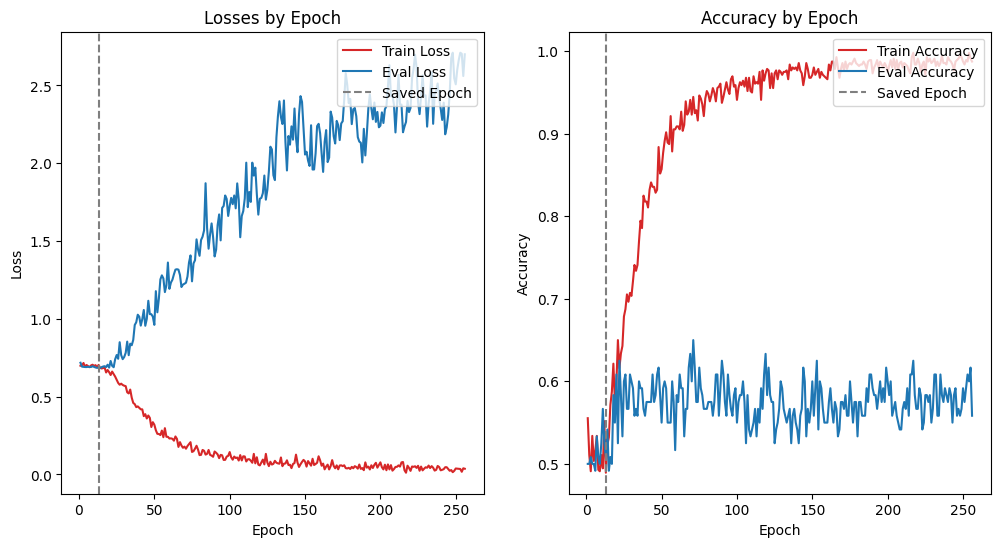

In [26]:
plot_train_eval_loss_accuracy(train_loss=trainer.train_losses,
                              train_accuracy=trainer.train_accuracies,
                              eval_loss=trainer.eval_losses,
                              eval_accuracy=trainer.eval_accuracies,
                              saved_epoch=best_eval_loss_epoch,
                              output_path=plots_dir,
                              output_file=f"model_attacker_pool_{model_id}_train_eval_loss_acc.png")

In [27]:
tester.test()

In [28]:
print(f'Test loss: {tester.loss:.4f}')
print(f'Test accuracy: {tester.accuracy_score:.2f}')
print(f'Test precision: {tester.precision_score:.2f}')
print(f'Test recall: {tester.recall_score:.2f}')
print(f'Test f1: {tester.f1_score:.2f}')
print(f'Test AUC: {tester.auroc_score:.2f}')

Test loss: 0.6938
Test accuracy: 0.51
Test precision: 0.51
Test recall: 0.68
Test f1: 0.58
Test AUC: 0.51


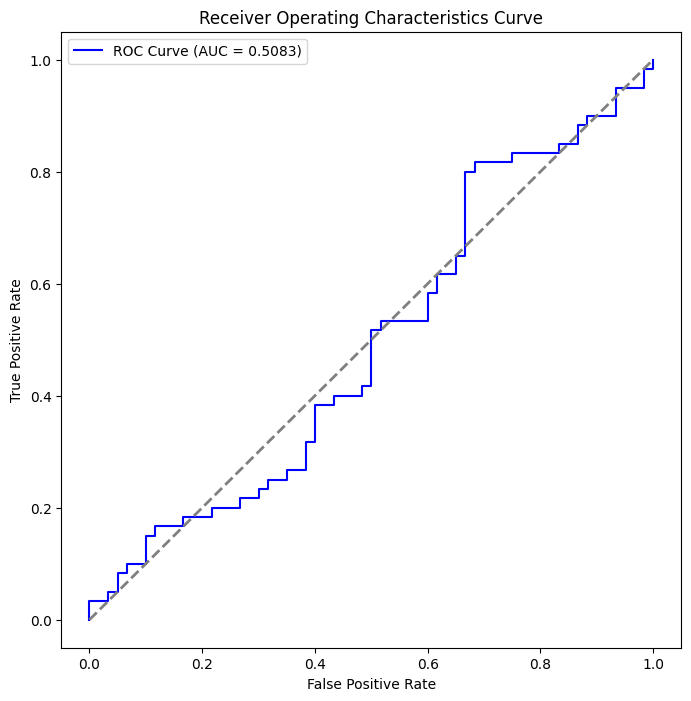

In [29]:
fpr, tpr, _ = tester.roc_curve
plot_receiver_operating_characteristics_curve(false_positive_rates=fpr,
                                              true_positive_rates=tpr,
                                              auc=tester.auroc_score,
                                              output_path=plots_dir,
                                              output_file=f"model_attacker_pool_{model_id}_roc_curve.png")

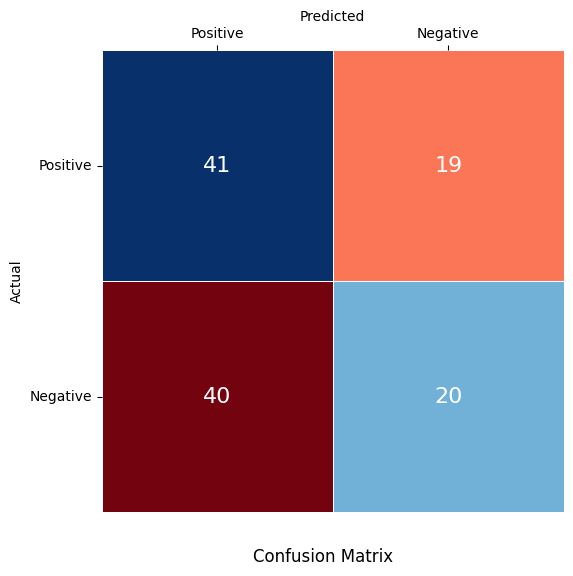

In [30]:
plot_confusion_matrix(confusion_matrix=tester.confusion_matrix_scores,
                      task="binary",
                      output_path=plots_dir,
                      output_file=f"model_attacker_pool_{model_id}_confusion_matrix.png")

In [31]:
manager.add_model(
    model_id=model_id,
    random_seed=random_seed,
    data=dataset,
    loader=dataloader_train,
    model=model,
    trainer=trainer,
    tester=tester)

In [ ]:
model.set_hidden_cell_mode(True)
model.eval()
with torch.no_grad():
    x, y = dataloader_test.dataset[0]
    x = x.unsqueeze(0).to(device)
    hx = None
    logits, out = model.forward(x, hx)
out_last = out[-1]
(h, c), (h_last, c_last) = out_last